In [1]:
# import packages and libraries
import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path

In [2]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [3]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [4]:
input_file = '../../01_Data/pumadyn_32nm_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[23:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
# validate on the random predictions from this range
actual_lows = {'theta1': -2.3555153, 'theta2': -2.3559486, 'theta3': -2.3556861000000002, 'theta4': -2.3554262,
                'theta5': -2.355844, 'theta6': -2.3558267999999996, 'thetad1': -2.3556139, 'thetad2': -2.3550772999999996,
                'thetad3': -2.3556497000000003,'thetad4': -2.3553389,'thetad5': -2.3550476000000002,'thetad6': -2.3561332999999998,
                'tau1': -74.990634, 'tau2': -74.937538, 'tau3': -74.978278, 'tau4': -74.999533, 'tau5': -74.984873,
                'dm1': 0.25026488,'dm2': 0.25041709, 'dm3': 0.25022193, 'dm4': 0.25007437, 'dm5': 0.25014939, 'da1': 0.25043561,
                'da2': 0.25057928, 'da3': 0.25008744, 'da4': 0.2501664, 'da5': 0.25061589, 'db1': 0.25005398,
                'db2': 0.25001159, 'db3': 0.25024083, 'db4': 0.25010881, 'db5': 0.2514393}
actual_highs = {'theta1': 2.35, 'theta2': 2.355, 'theta3': 2.355, 'theta4': 2.355,
                'theta5': 2.35,'theta6': 2.35,'thetad1': 2.35,'thetad2': 2.3540761000000003,'thetad3': 2.3547369,
                'thetad4': 2.3557772,'thetad5': 2.3557997999999998,'thetad6': 2.3558617,'tau1': 74.985591,'tau2': 74.967958,
                'tau3': 74.986797,'tau4': 74.99699100000001,'tau5': 74.995852,'dm1': 2.4999799,'dm2': 2.4994377999999995,
                'dm3': 2.4999333999999998,'dm4': 2.4999981,'dm5': 2.499663,'da1': 2.4991584,'da2': 2.4996680000000002,
                'da3': 2.4999561000000003,'da4': 2.4999662999999996,'da5': 2.4997887999999997,'db1': 2.4999776000000002,
                'db2': 2.4996115000000003,'db3': 2.4998112999999997,'db4': 2.4999968999999997,'db5': 2.4996541000000003}

variables_ = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'thetad1',
            'thetad2', 'thetad3', 'thetad4', 'thetad5', 'thetad6', 'tau1', 'tau2',
            'tau3', 'tau4', 'tau5', 'dm1', 'dm2', 'dm3', 'dm4', 'dm5', 'da1', 'da2',
            'da3', 'da4', 'da5', 'db1', 'db2', 'db3', 'db4', 'db5', 'thetadd6']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    df_doe[variables_[-1]] = model.predict(df_doe).round(2)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    df_doe[variables[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm


# df = random_generator(samples_, actual_lows, actual_highs, variables_, model)
# print(df['thetadd6'].min(), df['thetadd6'].max())

Validate

In [6]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 100
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 1
batchSize_gpr_al = 1
size_train_set = 400

committee_predictor = True
numCommitteeMembers = 3

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [7]:
#validation set
# size_test_set = 5000
reference_regr = model
# np.random.seed(83746293)
# test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
# test_data = np.array(test_data)
test_data = np.load(pth + 'lhc_test_pumadyn-32_sz_2000_randseed_83746293.npy')
size_test_set = test_data.shape[0]

# mcs_extension

In [8]:
#count_mcs = 0

In [9]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    for trainSize in trainingSetSizes_mcs:
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        # mlp_params_v1 = {
        #     'solver': 'adam', 'hidden_layer_sizes': (60, 60), 'activation': 'relu', 'tol': 1e-5, 'max_iter': 3000}
        # predictor = MLPRegressor(**mlp_params_v1)


        # mlp_params_v2 = {
        #     'solver': 'adam', 'hidden_layer_sizes': (120, 120, 120), 'activation': 'tanh', 'tol': 1e-5, 'max_iter': 1000}
        # predictor = MLPRegressor(**mlp_params_v2)

        lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        #np.random.seed(int(np.sqrt(2 + 0.1) * 1000))
        np.random.seed(seed_list[cv])
        train_data = np.array(random_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
        #mean_data, std_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))


        if committee_predictor:
            learner_list = []
            num_leaves = [6,11,16]
            for i in range(numCommitteeMembers):
                lgbmParams = {  # 'learning_rate': 0.1,
                    #'n_estimators': est[i],
                    'num_leaves': num_leaves[i],
                    'objective': 'regression',
                    'n_jobs': 7,
                    'random_state': i*100
                    }
                predictor = lightgbm.LGBMRegressor(**lgbmParams)
            learner_list.append(ActiveLearner(estimator=predictor,
                                              # estimator=sklearn.base.clone(predictor),
                                              X_training=X_train_norm,
                                              y_training=y_train_norm.ravel(),
                                              bootstrap_init=True))
            committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape((-1, 1)) - mcs_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))
        
        results_random.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 400: 0:00:00.687546 
val 1
Total time fold 1 trainSize 400: 0:00:01.024986 
val 2
Total time fold 2 trainSize 400: 0:00:00.936523 
val 3
Total time fold 3 trainSize 400: 0:00:00.852531 
val 4
Total time fold 4 trainSize 400: 0:00:00.846312 
val 5
Total time fold 5 trainSize 400: 0:00:00.808691 
val 6
Total time fold 6 trainSize 400: 0:00:00.721847 
val 7
Total time fold 7 trainSize 400: 0:00:00.719753 
val 8
Total time fold 8 trainSize 400: 0:00:00.656482 
val 9
Total time fold 9 trainSize 400: 0:00:00.688323 
val 10
Total time fold 10 trainSize 400: 0:00:00.663846 
val 11
Total time fold 11 trainSize 400: 0:00:00.661983 
val 12
Total time fold 12 trainSize 400: 0:00:00.653752 
val 13
Total time fold 13 trainSize 400: 0:00:00.659925 
val 14
Total time fold 14 trainSize 400: 0:00:00.665697 
val 15
Total time fold 15 trainSize 400: 0:00:00.661173 
val 16
Total time fold 16 trainSize 400: 0:00:00.679199 
val 17
Total time fold 17 trainSize 400: 0:00:00.70

In [10]:
res_df_random[res_df_random.Training_Size==150]

,Model,CV,Training_Size,RMSE,r2_val
10,LGBMRegressor,0,150,0.014825,0.700303
71,LGBMRegressor,1,150,0.012195,0.797211
132,LGBMRegressor,2,150,0.020125,0.447751
193,LGBMRegressor,3,150,0.010120,0.860340
254,LGBMRegressor,4,150,0.009434,0.878636
315,LGBMRegressor,5,150,0.012468,0.788043
376,LGBMRegressor,6,150,0.016424,0.632199
437,LGBMRegressor,7,150,0.011085,0.832434
498,LGBMRegressor,8,150,0.008113,0.910249
559,LGBMRegressor,9,150,0.010972,0.835862


In [11]:
res_df_random[res_df_random.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.004847,0.967971
121,LGBMRegressor,1,400,0.005036,0.965424
182,LGBMRegressor,2,400,0.005050,0.965231
243,LGBMRegressor,3,400,0.005217,0.962885
304,LGBMRegressor,4,400,0.004880,0.967533
365,LGBMRegressor,5,400,0.006315,0.945627
426,LGBMRegressor,6,400,0.005156,0.963743
487,LGBMRegressor,7,400,0.005022,0.965607
548,LGBMRegressor,8,400,0.005187,0.963313
609,LGBMRegressor,9,400,0.005004,0.965851


# lhc

In [12]:
#count_lhc = 0

In [13]:
numCommitteeMembers = 3

results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
        try:
            fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            train_data =  np.load(pth + fname_t)
            pool_data = np.load(pth + fname_p)
        except:
            print('lhc file not found')
            train_data = np.array(
                latin_hypercube_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
            #print(train_data[0])
            pool_data = np.array(latin_hypercube_generator(size_train_set, actual_lows, actual_highs, variables_,
                                      reference_regr))
            fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            np.save(pth + fname_t, train_data)
            np.save(pth + fname_p, pool_data)
        
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]
        
        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

        
        if committee_predictor:
            learner_list = []
            num_leaves = [6,11,16]
            for i in range(numCommitteeMembers):
                lgbmParams = {  # 'learning_rate': 0.1,
                    #'n_estimators': est[i],
                    'num_leaves': num_leaves[i],
                    'objective': 'regression',
                    'n_jobs': 7,
                    'random_state': i*100
                    }
                predictor = lightgbm.LGBMRegressor(**lgbmParams)
                learner_list.append(ActiveLearner(estimator=predictor,
                                                  # estimator=sklearn.base.clone(predictor),
                                                  X_training=X_train_norm,
                                                  y_training=y_train_norm.ravel(),
                                                  bootstrap_init=True))
                committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
                    max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_lhc = pd.DataFrame(results_lhc)

    # count_lhc+=1

seed 0
Total time fold 0 trainSize 400: 0:00:00.712657 
seed 1
Total time fold 1 trainSize 400: 0:00:00.716616 
seed 2
Total time fold 2 trainSize 400: 0:00:00.717225 
seed 3
Total time fold 3 trainSize 400: 0:00:00.711921 
seed 4
Total time fold 4 trainSize 400: 0:00:00.713910 
seed 5
Total time fold 5 trainSize 400: 0:00:00.710690 
seed 6
Total time fold 6 trainSize 400: 0:00:00.710188 
seed 7
Total time fold 7 trainSize 400: 0:00:00.704610 
seed 8
Total time fold 8 trainSize 400: 0:00:00.705444 
seed 9
Total time fold 9 trainSize 400: 0:00:00.710667 
seed 10
Total time fold 10 trainSize 400: 0:00:00.708819 
seed 11
Total time fold 11 trainSize 400: 0:00:00.706260 
seed 12
Total time fold 12 trainSize 400: 0:00:00.708445 
seed 13
Total time fold 13 trainSize 400: 0:00:00.715270 
seed 14
Total time fold 14 trainSize 400: 0:00:00.710579 
seed 15
Total time fold 15 trainSize 400: 0:00:00.707625 
seed 16
Total time fold 16 trainSize 400: 0:00:00.712901 
seed 17
Total time fold 17 trainSi

In [14]:
res_df_lhc[res_df_lhc.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,100,0.018122,0.552200
61,LGBMRegressor,1,100,0.019533,0.479750
122,LGBMRegressor,2,100,0.019644,0.473798
183,LGBMRegressor,3,100,0.021606,0.363454
244,LGBMRegressor,4,100,0.018563,0.530143
305,LGBMRegressor,5,100,0.022972,0.280399
366,LGBMRegressor,6,100,0.025856,0.088428
427,LGBMRegressor,7,100,0.021601,0.363743
488,LGBMRegressor,8,100,0.024248,0.198242
549,LGBMRegressor,9,100,0.023062,0.274757


In [15]:
res_df_lhc[res_df_lhc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.006055,0.950008
121,LGBMRegressor,1,400,0.005601,0.957226
182,LGBMRegressor,2,400,0.007732,0.918478
243,LGBMRegressor,3,400,0.006091,0.949407
304,LGBMRegressor,4,400,0.005296,0.961756
365,LGBMRegressor,5,400,0.006727,0.938296
426,LGBMRegressor,6,400,0.005317,0.961444
487,LGBMRegressor,7,400,0.005759,0.954779
548,LGBMRegressor,8,400,0.005866,0.953077
609,LGBMRegressor,9,400,0.005415,0.960011


# AL with qbc

In [16]:
#count_qbc = 0

In [17]:
# cv_folds = 10

In [18]:
from sklearn.ensemble import RandomForestRegressor

count_qbc= 0
PoolSetSize = 600 #260#260 #400
batchSize = 5
seedSize = 100
n_queries = 60

numCommitteeMembers = 3

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    #est = [100, 120, 140]
    num_leaves = [6,11,16]
    #num_leaves = [8,11,14]
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            #'n_estimators': est[i],
            'num_leaves': num_leaves[i],
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
#         predictor = RandomForestRegressor(max_depth=num_leaves[i], 
#                                   random_state=i*100, 
#                                   #n_estimators=100, 
#                                   n_jobs=1)
        learner_list.append(ActiveLearner(estimator=predictor,
                                          # estimator=sklearn.base.clone(predictor),
                                          X_training=X_train_norm,
                                          y_training=y_train_norm.ravel(),
                                          bootstrap_init=True))
    committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    np.random.seed(seed_list[cv])
    print('seed {}'.format(cv))
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    try:
        fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data =  np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(
            latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
                                  reference_regr))
        fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)

    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    #print(X_train_norm[0])


    committee.fit(X_train_norm, y_train_norm.ravel())
     #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    #print('QBC before, train size {}'.format(X_train_norm.shape[0]))
    #print(r2_score(targets_qbc, preds_qbc))



    for itter in range(n_queries+1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx],
                        y_pool_norm.ravel()[query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 0
Total time fold 0 trainSize 405: 0:00:00.928064 
seed 1
Total time fold 1 trainSize 405: 0:00:00.933060 
seed 2
Total time fold 2 trainSize 405: 0:00:00.925000 
seed 3
Total time fold 3 trainSize 405: 0:00:00.940892 
seed 4
Total time fold 4 trainSize 405: 0:00:00.921038 
seed 5
Total time fold 5 trainSize 405: 0:00:00.922141 
seed 6
Total time fold 6 trainSize 405: 0:00:00.919098 
seed 7
Total time fold 7 trainSize 405: 0:00:00.923294 
seed 8
Total time fold 8 trainSize 405: 0:00:00.946062 
seed 9
Total time fold 9 trainSize 405: 0:00:00.922429 
seed 10
Total time fold 10 trainSize 405: 0:00:00.928676 
seed 11
Total time fold 11 trainSize 405: 0:00:00.926838 
seed 12
Total time fold 12 trainSize 405: 0:00:00.929324 
seed 13
Total time fold 13 trainSize 405: 0:00:00.924685 
seed 14
Total time fold 14 trainSize 405: 0:00:00.924871 
seed 15
Total time fold 15 trainSize 405: 0:00:00.921970 
seed 16
Total time fold 16 trainSize 405: 0:00:00.929480 
seed 17
Total time fold 17 trainSi

In [19]:
res_df_qbc[res_df_qbc.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,100,0.018122,0.552200
61,LGBMRegressor,1,100,0.019533,0.479750
122,LGBMRegressor,2,100,0.019644,0.473798
183,LGBMRegressor,3,100,0.021606,0.363454
244,LGBMRegressor,4,100,0.018651,0.525646
305,LGBMRegressor,5,100,0.022972,0.280399
366,LGBMRegressor,6,100,0.025856,0.088428
427,LGBMRegressor,7,100,0.021601,0.363743
488,LGBMRegressor,8,100,0.024248,0.198242
549,LGBMRegressor,9,100,0.023063,0.274740


In [20]:
res_df_qbc[res_df_qbc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.004521,0.972124
121,LGBMRegressor,1,400,0.005402,0.960208
182,LGBMRegressor,2,400,0.005275,0.962056
243,LGBMRegressor,3,400,0.005341,0.961107
304,LGBMRegressor,4,400,0.004921,0.966986
365,LGBMRegressor,5,400,0.004594,0.971224
426,LGBMRegressor,6,400,0.004388,0.973751
487,LGBMRegressor,7,400,0.004676,0.970180
548,LGBMRegressor,8,400,0.005001,0.965900
609,LGBMRegressor,9,400,0.005161,0.963676


# AL with Gaussian Process Regressor

In [21]:
# count_gpr = 0

In [22]:
# import warnings
# warnings.filterwarnings("ignore")

# def GP_regression_std(regressor, X):
#     _, std = regressor.predict(X, return_std=True)
#     query_idx = np.argmax(std)
#     return query_idx, X[query_idx]

# numCommitteeMembers = 3
# PoolSetSize = 601
# seedSize = 150

# results_al_gpr = []
# for cv in range(cv_folds):
#     startTime = datetime.now()
#     print('seed {}'.format(cv))
#     for i in range(numCommitteeMembers):
#         lgbmParams = {  # 'learning_rate': 0.1,
#             'n_estimators': 100,
#             'objective': 'regression',
#             'n_jobs': 7,
#             'random_state': i
#             }
#         predictor = lightgbm.LGBMRegressor(**lgbmParams)
# #         learner_list.append(ActiveLearner(estimator=predictor,
# #                                           # estimator=sklearn.base.clone(predictor),
# #                                           X_training=X_train_norm,
# #                                           y_training=y_train_norm.ravel(),
# #                                           bootstrap_init=True))
# #     committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    
#     np.random.seed(seed_list[cv])
    
#     try:
#         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#         train_data =  np.load(pth + fname_t)
#         pool_data = np.load(pth + fname_p)
#     except:
#         print('lhc file not found')
#         np.random.seed(seed_list[cv])
#         train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#         pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
#                                   reference_regr))
#         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
#         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
#         np.save(pth + fname_t, train_data)
#         np.save(pth + fname_p, pool_data)
    
# #     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
# #     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    
#     # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
#     min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
#     X_train = train_data[:, :-1]
#     X_pool = pool_data[:, :-1]
#     y_train = train_data[:, -1].reshape((-1, 1))
#     y_pool = pool_data[:, -1].reshape((-1, 1))
#     X_test = test_data[:, :-1]
#     y_test = test_data[:, -1]

#     # NORMALIZED DATA
#     X_train_norm = data_all_norm[:train_data.shape[0], :-1]
#     y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
#     X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
#     y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
#     X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
#     y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
#     # Create GPR as an active learner
#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#     committee = ActiveLearner(
#         estimator=GaussianProcessRegressor(kernel=kernel),
#         query_strategy=GP_regression_std,
#         X_training=X_train_norm, y_training=y_train_norm.ravel()
#         )
    
#     committee.fit(X_train_norm, y_train_norm.ravel())
#     for itter in range(size_train_set-seedSize+1):
#         if committee_predictor:
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = committee.predict(X_test_norm)
#         else:
#             #  -------->  MODEL FITTING  <------------------
#             predictor.fit(X_train_norm, y_train_norm.ravel())
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = predictor.predict(X_test_norm)

#         # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
#         al_gpr_y = max_data[-1].reshape((-1, 1)) - al_gpr_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
#         preds_al_gpr = np.ravel(al_gpr_y)
#         targets_al_gpr = np.ravel(y_test)
        
#         r2_val = r2_score(targets_al_gpr, preds_al_gpr)
#         rmse_val = rmse(targets_al_gpr, preds_al_gpr)

#         results_al_gpr.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
#                        'RMSE': rmse_val, 'r2_val': r2_val})

#         # -------->  Pick new point  <------------------
#         query_idx, query_instance = committee.query(X=X_pool_norm)
#         X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
#         y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
#         committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())  # train committee on newly added data
#         X_pool = np.delete(X_pool, query_idx, axis=0)
#         y_pool = np.delete(y_pool, query_idx, axis=0)
#         X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
#         y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)

#     endTime = datetime.now()
#     print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
        
# res_df_al_gpr = pd.DataFrame(results_al_gpr)

In [23]:
# res_df_al_gpr[res_df_al_gpr.Training_Size==150]

In [24]:
# res_df_al_gpr[res_df_al_gpr.Training_Size==400]

# Visualize

In [25]:
# metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
#     size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
#     committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

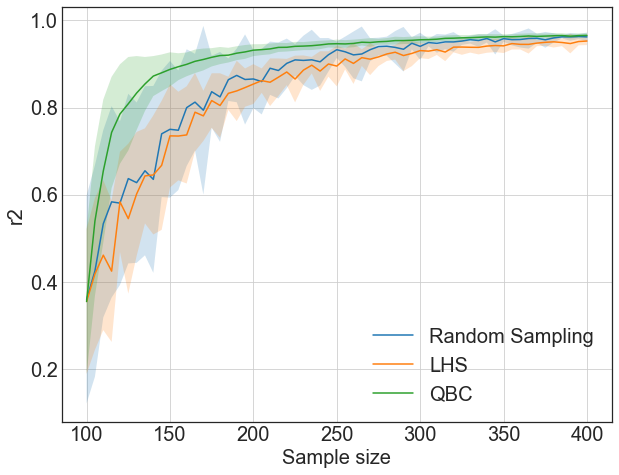

In [31]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'Random Sampling', metadata)
        plot_learning_curve_r2(res_df_lhc, 'LHS', metadata)
        plot_learning_curve_r2(res_df_qbc, 'QBC', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('puma_32_nm_al_lhc_mcs_results_Bagging_' + mdl + '.png', dpi=300)
        plt.show()

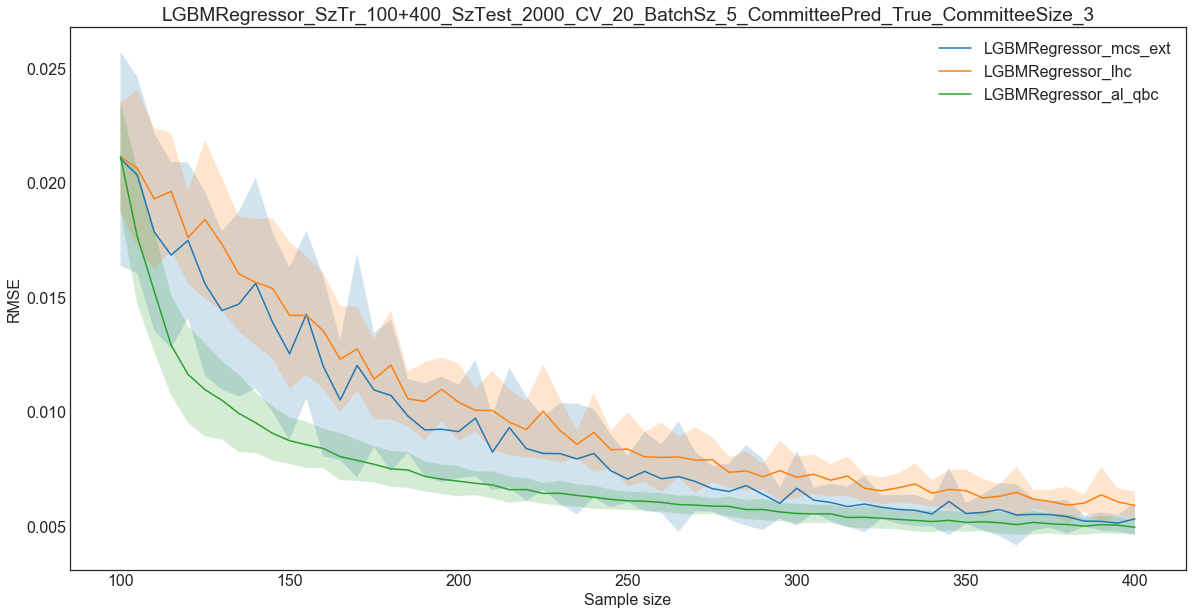

In [36]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [37]:
count_gpr = 0

In [38]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 0
AL GPR before, train size 150
0.35971068791557337
AL GPR after, train size 400
0.9509289174435879


# Tune QBC

In [39]:
count_qbc= 0

In [40]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      bootstrap_init=True))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.7204216640160488
size 155, r2 0.8072464651684432
size 160, r2 0.7008699157277987
size 165, r2 0.7441966723168592
size 170, r2 0.7012214921454598
size 175, r2 0.6784841472142864
size 180, r2 0.6634040808795132
size 185, r2 0.6548119736333662
size 190, r2 0.6470952384276506
size 195, r2 0.6780689482231372
size 200, r2 0.7063936241674889
size 205, r2 0.6938304743563647
size 210, r2 0.7313977935636569
size 215, r2 0.7243408233988224
size 220, r2 0.7273162508160891
size 225, r2 0.7506433710485618
size 230, r2 0.7447792546078045
size 235, r2 0.7470748835507881
size 240, r2 0.6980990995698064
size 245, r2 0.6967014223022082
size 250, r2 0.703253789243659
size 255, r2 0.6893742968801817
size 260, r2 0.7135522851623057
size 265, r2 0.7102725804537444
size 270, r2 0.7362887210707618
size 275, r2 0.7364627609140906
size 280, r2 0.7549528086475158
size 285, r2 0.827390544783259
size 290, r2 0.8351037547707791
size 295, r2 0.8315357935139353
size 300, r2 0.85440872221852

In [41]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9704712301849828


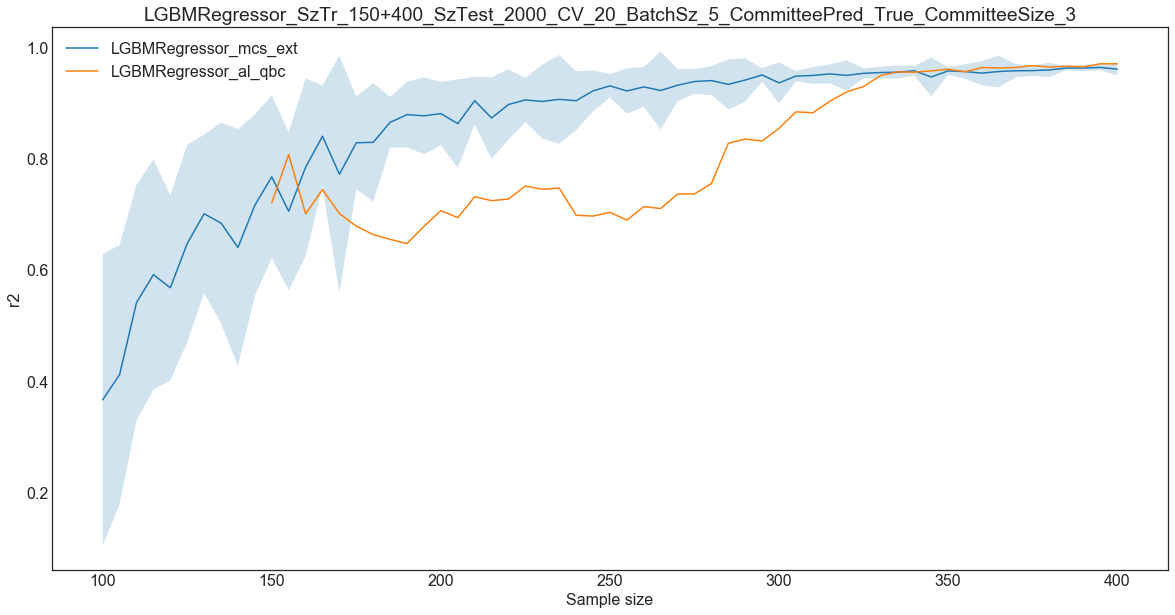

In [42]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_al_gpr' is not defined

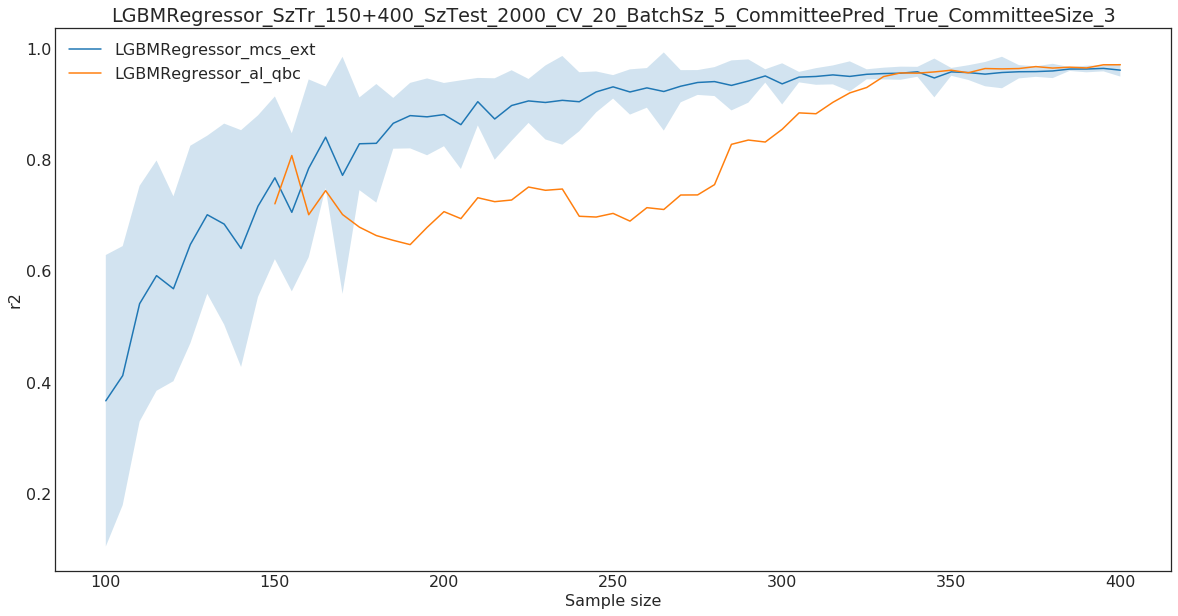

In [43]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()